In [115]:
# import italy_house_prices/rome_rents_clean_our_version.csv into a pandas dataframe
import pandas as pd
FILE = './italy-house-prices/rome_rents_clean_our_version.csv'
df = pd.read_csv(FILE, encoding='latin-1')
# print ALL column names
df.columns.tolist()

['prezzo',
 'spese_condominio',
 'm2',
 'rooms',
 'more_than_5_rooms',
 'floor',
 'ascensore',
 'accesso_disabili',
 'piano_rialzato',
 'multi_floor',
 'totale_piani_edificio',
 'ultimo_piano',
 'affitto',
 'affitto_libero',
 'affitto_durata_minima',
 'affitto_durata_rinnovo',
 'affitto_concordato',
 'affitto_transitorio',
 'affitto_studenti',
 'affitto_riscatto',
 'immobile_a_reddito',
 'totale_locali',
 'camere_da_letto',
 'altri_locali',
 'campo_da_tennis',
 'cucina_',
 'cucina_a vista',
 'cucina_abitabile',
 'cucina_angolo cottura',
 'cucina_cucinotto',
 'cucina_semi abitabile',
 'bathrooms',
 'more_than_3_bathrooms',
 'bathrooms_per_locali',
 'garage_box',
 'esterno',
 'parcheggio_comune',
 'box_privato',
 'has_garage_box',
 'has_esterno',
 'has_parcheggio_comune',
 'has_box_privato',
 'stato_condition_Buono',
 'stato_condition_Da ristrutturare',
 'stato_condition_Nuovo',
 'stato_condition_Ottimo',
 'stato_condition_Unknown',
 'stato_renovation_Abitabile',
 'stato_renovation_In co

In [116]:
from scipy import stats
import numpy as np

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def detect_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column].dropna()))
    return z_scores > threshold

from scipy.stats.mstats import winsorize

def cap_outliers(df, columns, method='iqr'):
    df_clean = df.copy()
    
    for col in columns:
        if method == 'iqr':
            lower, upper = detect_outliers_iqr(df, col)
        elif method == 'zscore':
            z_scores = np.abs(stats.zscore(df[col].dropna()))
            threshold = 3
            lower = df[col][z_scores <= threshold].min()
            upper = df[col][z_scores <= threshold].max()
        elif method == 'quantile':
            lower = df[col].quantile(0.01)  # 1st percentile
            upper = df[col].quantile(0.99)  # 99th percentile
        
        df_clean[col] = np.clip(df_clean[col], lower, upper)
    
    return df_clean

# Apply to your key features
numerical_cols = ['prezzo', 'm2', 'rooms', 'bathrooms']
df_clean = cap_outliers(df, numerical_cols)

df_clean = df_clean.dropna(thresh=len(df.columns) - 3) # allow max 3 missing values per row

# how many rows were removed?
print(f"Rows before treatment: {len(df)}")
print(f"Rows after treatment: {len(df_clean)}")
df = df_clean

Rows before treatment: 12962
Rows after treatment: 11915


## Linear Regression: Ordinarily Least Squares

In [117]:
# do ordinary least squares regression to predict rent price 
# put it in a pipeline, do regularization (SimpleScaler) and imputer for missing data
# handle outliers in the pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df.drop('prezzo', axis=1)
y = df['prezzo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('linear', LinearRegression())
])
linear_pipeline.fit(X_train, y_train)
y_pred = linear_pipeline.predict(X_test)

In [118]:
# print mean absolute error, mean squared error and r2 score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')

# print some prediction vs actual value with error
print("\n=== Sample Predictions vs Actual Values ===")
for i in range(min(10, len(y_test))):
    actual = y_test.iloc[i]
    predicted = y_pred[i]
    error = abs(actual - predicted)
    error_pct = (error / actual) * 100
    print(f"Sample {i+1}: Actual=€{actual:.2f}, Predicted=€{predicted:.2f}, Error=€{error:.2f} ({error_pct:.1f}%)")

MAE: 211.96465001935823, MSE: 91617.81872758818, R2: 0.8175282181551071

=== Sample Predictions vs Actual Values ===
Sample 1: Actual=€700.00, Predicted=€700.10, Error=€0.10 (0.0%)
Sample 2: Actual=€700.00, Predicted=€919.49, Error=€219.49 (31.4%)
Sample 3: Actual=€700.00, Predicted=€674.40, Error=€25.60 (3.7%)
Sample 4: Actual=€600.00, Predicted=€591.64, Error=€8.36 (1.4%)
Sample 5: Actual=€600.00, Predicted=€717.62, Error=€117.62 (19.6%)
Sample 6: Actual=€1750.00, Predicted=€1891.87, Error=€141.87 (8.1%)
Sample 7: Actual=€550.00, Predicted=€527.90, Error=€22.10 (4.0%)
Sample 8: Actual=€1800.00, Predicted=€1821.06, Error=€21.06 (1.2%)
Sample 9: Actual=€2825.00, Predicted=€2098.77, Error=€726.23 (25.7%)
Sample 10: Actual=€700.00, Predicted=€826.54, Error=€126.54 (18.1%)


## Linear Regression: Lasso Regularization

In [119]:
# do lasso regression to predict rent prices based on the other features
# put it in a pipeline, do regularization (SimpleScaler) and imputer for missing data
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('prezzo', axis=1)
y = df['prezzo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lasso_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=1000, alpha=1))
])
lasso_pipeline.fit(X_train, y_train)
y_pred = lasso_pipeline.predict(X_test)

In [120]:
# Split the dataset into training, validation, and test sets
from sklearn.model_selection import train_test_split

# First split into training+validation and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then split training+validation into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Perform cross-validation to find the best alpha for Lasso regression
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for alpha
param_grid = {'lasso__alpha': [0.01, 0.1, 1, 10, 100]}

# Set up GridSearchCV with the pipeline
grid_search = GridSearchCV(lasso_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best alpha and the corresponding score
best_alpha = grid_search.best_params_['lasso__alpha']
best_score = -grid_search.best_score_
print(f"Best alpha: {best_alpha}")
print(f"Best cross-validated MSE: {best_score}")

# Refit the pipeline with the best alpha
lasso_pipeline.set_params(lasso__alpha=best_alpha)
lasso_pipeline.fit(X_train, y_train)

# Evaluate on the validation set
y_val_pred = lasso_pipeline.predict(X_val)
from sklearn.metrics import mean_squared_error
val_mse = mean_squared_error(y_val, y_val_pred)
print(f"Validation MSE: {val_mse}")

# Finally, evaluate on the test set
y_test_pred = lasso_pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")

/mnt/c/Users/anton/Documents/_projects/rome-rent-ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.668e+07, tolerance: 2.814e+05
  model = cd_fast.enet_coordinate_descent(
/mnt/c/Users/anton/Documents/_projects/rome-rent-ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.554e+07, tolerance: 2.913e+05
  model = cd_fast.enet_coordinate_descent(
/mnt/c/Users/anton/Documents/_projects/rome-rent-ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increa

Best alpha: 1
Best cross-validated MSE: 95207.8562770418
Validation MSE: 89563.27101169295
Test MSE: 92216.1574403304
Validation MSE: 89563.27101169295
Test MSE: 92216.1574403304


In [121]:
# calculate mean absolute error, mean squared error and r2 score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')

# print the worst 10 predictions with highest absolute error
print("\n=== Worst 10 Predictions by Absolute Error ===")
errors = abs(y_test - y_pred)
worst_10_indices = errors.nlargest(10).index
for i in worst_10_indices:
    actual = y_test.loc[i]
    predicted = y_pred[list(y_test.index).index(i)]
    error = abs(actual - predicted)
    error_pct = (error / actual) * 100
    print(f"Index {i}: Actual=€{actual:.2f}, Predicted=€{predicted:.2f}, Error=€{error:.2f} ({error_pct:.1f}%)")


MAE: 210.71590852629373, MSE: 91651.41160117163, R2: 0.8174613124856076

=== Worst 10 Predictions by Absolute Error ===
Index 11665: Actual=€2825.00, Predicted=€774.15, Error=€2050.85 (72.6%)
Index 306: Actual=€2825.00, Predicted=€856.40, Error=€1968.60 (69.7%)
Index 5436: Actual=€2825.00, Predicted=€1296.11, Error=€1528.89 (54.1%)
Index 9361: Actual=€2500.00, Predicted=€1069.74, Error=€1430.26 (57.2%)
Index 8100: Actual=€2825.00, Predicted=€1562.84, Error=€1262.16 (44.7%)
Index 12403: Actual=€2825.00, Predicted=€1573.67, Error=€1251.33 (44.3%)
Index 3695: Actual=€2825.00, Predicted=€1609.21, Error=€1215.79 (43.0%)
Index 8609: Actual=€350.00, Predicted=€1562.15, Error=€1212.15 (346.3%)
Index 4497: Actual=€2500.00, Predicted=€1302.91, Error=€1197.09 (47.9%)
Index 8373: Actual=€2800.00, Predicted=€1629.43, Error=€1170.57 (41.8%)


In [122]:
# print the coefficients of the lasso regression, ordered by weight
lasso = lasso_pipeline.named_steps['lasso']
coefficients = lasso.coef_
feature_names = X.columns
# print how many features have non-zero coefficients
non_zero_coeffs = sum(coef != 0 for coef in coefficients)
print(f'\nNumber of features with non-zero coefficients: {non_zero_coeffs}\n')
for feature, coef in sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True):
    print(f'{feature}: {coef}')


Number of features with non-zero coefficients: 310

m2: 204.3859996290834
quartiere_Sallustiano: 129.28907152224852
immobile_di_lusso: 116.39624642022548
bathrooms: 112.80576626383316
quartiere_Piazza Navona: 79.50558667711158
quartiere_Trastevere: 72.46633885971904
quartiere_Piazza del Popolo: 69.99973976035552
quartiere_Spagna: 68.15985783843573
quartiere_Barberini: 56.863943785133564
quartiere_Flaminio: 53.80223026837085
quartiere_Parioli: 53.40362285081579
totale_locali: 51.61162500501238
quartiere_Euclide: 51.58632725741078
quartiere_Vittorio Veneto: 51.35172907660923
quartiere_Cipro: 50.991822110131
quartiere_Mazzini - Delle Vittorie: 50.988538450037545
quartiere_Borgo: 47.51567928868123
portiere: 47.091547629470384
bathrooms_per_locali: -45.311791303107306
quartiere_Colle Oppio: 43.647158973945984
quartiere_Monti: 43.576608978544144
quartiere_Bologna: 43.226858872381506
quartiere_Aventino: 42.9482584631383
affitto_durata_minima: -42.450841023585795
quartiere_Repubblica: 41.4021

### Linear Regression: Ridge Regularization

In [123]:
# Perform Ridge regression with cross-validation to find the best alpha
from sklearn.linear_model import Ridge

# Create a new pipeline for Ridge regression
ridge_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(max_iter=1000))
])

# Define the parameter grid for alpha
ridge_param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

# Set up GridSearchCV with the Ridge pipeline
ridge_grid_search = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_train, y_train)

# Get the best alpha and the corresponding score
ridge_best_alpha = ridge_grid_search.best_params_['ridge__alpha']
ridge_best_score = -ridge_grid_search.best_score_
print(f"Best alpha for Ridge: {ridge_best_alpha}")
print(f"Best cross-validated MSE for Ridge: {ridge_best_score}")

# Refit the Ridge pipeline with the best alpha
ridge_pipeline.set_params(ridge__alpha=ridge_best_alpha)
ridge_pipeline.fit(X_train, y_train)

# Evaluate on the validation set
y_val_pred_ridge = ridge_pipeline.predict(X_val)
ridge_val_mse = mean_squared_error(y_val, y_val_pred_ridge)
print(f"Validation MSE for Ridge: {ridge_val_mse}")

# Finally, evaluate on the test set
y_test_pred_ridge = ridge_pipeline.predict(X_test)
ridge_test_mse = mean_squared_error(y_test, y_test_pred_ridge)
print(f"Test MSE for Ridge: {ridge_test_mse}")

Best alpha for Ridge: 100
Best cross-validated MSE for Ridge: 100596.8308133976
Validation MSE for Ridge: 89643.43890072968
Test MSE for Ridge: 92053.93182262089
Validation MSE for Ridge: 89643.43890072968
Test MSE for Ridge: 92053.93182262089


In [124]:
# do ridge regression to predict rent prices based on the other features
# put it in a pipeline, do regularization (SimpleScaler) and imputer for missing data
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X = df.drop('prezzo', axis=1)
y = df['prezzo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(max_iter=1000, alpha=100))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [125]:
# print absolute mean error, mean squared error and r2 score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')

# print a sample of predictions vs actual value with error
print("\n=== Sample Predictions vs Actual Values (Ridge) ===")
for i in range(min(10, len(y_test))):   
    actual = y_test.iloc[i]
    predicted = y_pred[i]
    error = abs(actual - predicted)
    error_pct = (error / actual) * 100
    print(f"Sample {i+1}: Actual=€{actual:.2f}, Predicted=€{predicted:.2f}, Error=€{error:.2f} ({error_pct:.1f}%)")

MAE: 211.46502641223057, MSE: 91371.00560018972, R2: 0.8180197866268804

=== Sample Predictions vs Actual Values (Ridge) ===
Sample 1: Actual=€700.00, Predicted=€694.97, Error=€5.03 (0.7%)
Sample 2: Actual=€700.00, Predicted=€917.60, Error=€217.60 (31.1%)
Sample 3: Actual=€700.00, Predicted=€671.43, Error=€28.57 (4.1%)
Sample 4: Actual=€600.00, Predicted=€591.50, Error=€8.50 (1.4%)
Sample 5: Actual=€600.00, Predicted=€724.01, Error=€124.01 (20.7%)
Sample 6: Actual=€1750.00, Predicted=€1878.20, Error=€128.20 (7.3%)
Sample 7: Actual=€550.00, Predicted=€530.23, Error=€19.77 (3.6%)
Sample 8: Actual=€1800.00, Predicted=€1822.06, Error=€22.06 (1.2%)
Sample 9: Actual=€2825.00, Predicted=€2031.87, Error=€793.13 (28.1%)
Sample 10: Actual=€700.00, Predicted=€810.30, Error=€110.30 (15.8%)


In [126]:
# print the coefficients of the ridge regression
ridge = pipeline.named_steps['ridge']
coefficients = ridge.coef_
feature_names = X.columns
print('\nRidge Regression Coefficients:')
for feature, coef in sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True):
    print(f'{feature}: {coef}')


Ridge Regression Coefficients:
m2: 203.62967310033383
quartiere_Sallustiano: 121.99966678623834
bathrooms: 109.80286099685274
immobile_di_lusso: 107.37580911259045
affitto_durata_minima: -71.5124117291494
totale_locali: 68.74975658946666
quartiere_Piazza Navona: 68.59334930876813
affitto_durata_rinnovo: 62.689578949404684
quartiere_Piazza del Popolo: 62.62464760280427
quartiere_Spagna: 57.872669511896156
quartiere_Trastevere: 53.50032919885895
portiere: 48.68862411814311
quartiere_Barberini: 48.11997117469854
bathrooms_per_locali: -45.70502538481719
quartiere_Vittorio Veneto: 44.1693112126259
quartiere_Flaminio: 43.15337021805379
quartiere_Borghesiana: -40.30907423786176
quartiere_Mazzini - Delle Vittorie: 40.151937763104684
quartiere_Cipro: 40.14647197599283
affitto_libero: -39.37203001913158
affitto_concordato: -39.26463430824574
cauzione: 38.13870066630313
quartiere_Euclide: 37.54217471120052
quartiere_Colle Oppio: 37.533735476651316
quartiere_Borgo: 36.52272062906452
quartiere_Ave

In [133]:
import matplotlib.pyplot as plt
# show coefficients of ols, lasso and ridge regression in separate graphs for better visibility
ols = linear_pipeline.named_steps['linear']
lasso = lasso_pipeline.named_steps['lasso']
ridge = ridge_pipeline.named_steps['ridge']

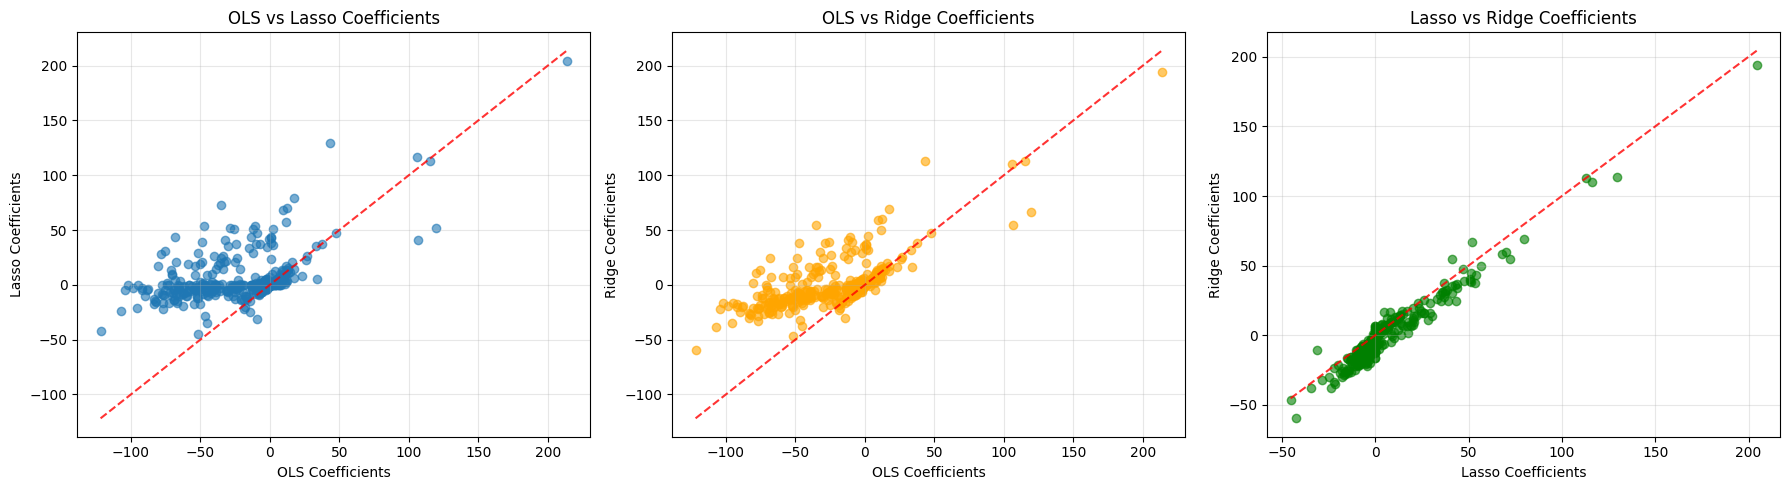

In [134]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# OLS vs Lasso
axes[0].scatter(ols.coef_, lasso.coef_, alpha=0.6)
axes[0].plot([ols.coef_.min(), ols.coef_.max()], [ols.coef_.min(), ols.coef_.max()], 'r--', alpha=0.8)
axes[0].set_xlabel('OLS Coefficients')
axes[0].set_ylabel('Lasso Coefficients')
axes[0].set_title('OLS vs Lasso Coefficients')
axes[0].grid(True, alpha=0.3)

# OLS vs Ridge
axes[1].scatter(ols.coef_, ridge.coef_, alpha=0.6, color='orange')
axes[1].plot([ols.coef_.min(), ols.coef_.max()], [ols.coef_.min(), ols.coef_.max()], 'r--', alpha=0.8)
axes[1].set_xlabel('OLS Coefficients')
axes[1].set_ylabel('Ridge Coefficients')
axes[1].set_title('OLS vs Ridge Coefficients')
axes[1].grid(True, alpha=0.3)

# Lasso vs Ridge
axes[2].scatter(lasso.coef_, ridge.coef_, alpha=0.6, color='green')
axes[2].plot([lasso.coef_.min(), lasso.coef_.max()], [lasso.coef_.min(), lasso.coef_.max()], 'r--', alpha=0.8)
axes[2].set_xlabel('Lasso Coefficients')
axes[2].set_ylabel('Ridge Coefficients')
axes[2].set_title('Lasso vs Ridge Coefficients')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

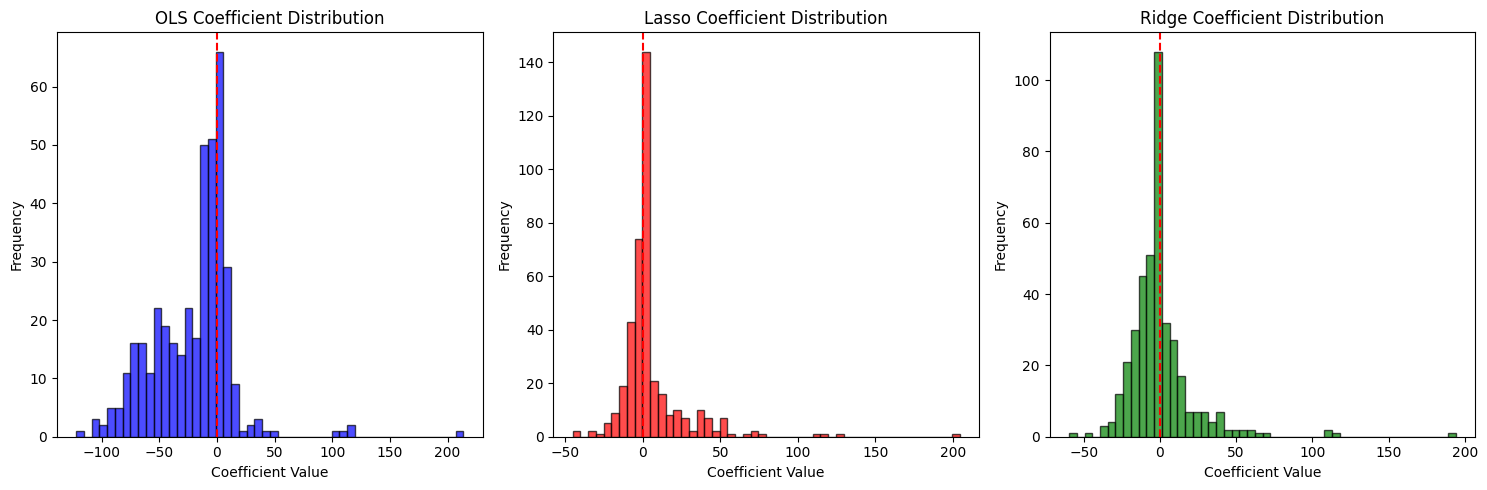

In [135]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(ols.coef_, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('OLS Coefficient Distribution')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')

plt.subplot(1, 3, 2)
plt.hist(lasso.coef_, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title('Lasso Coefficient Distribution')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')

plt.subplot(1, 3, 3)
plt.hist(ridge.coef_, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Ridge Coefficient Distribution')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

In [144]:
def get_top_features_by_coefficient(model, feature_names, top_n=20):
    """
    Get top features based on absolute coefficient values
    """
    # Create DataFrame with coefficients
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': model.coef_,
        'abs_coefficient': np.abs(model.coef_)
    })
    
    # Sort by absolute coefficient
    top_features = coef_df.sort_values('abs_coefficient', ascending=False).head(top_n)
    
    return top_features

# Get top features for each model
top_ols = get_top_features_by_coefficient(ols, feature_names, 20)
top_lasso = get_top_features_by_coefficient(lasso, feature_names, 20) 
top_ridge = get_top_features_by_coefficient(ridge, feature_names, 20)

print("OLS Top 10 Features:")
print(top_ols[['feature', 'coefficient']].head(10))
print("\nLasso Top 10 Features:")
print(top_lasso[['feature', 'coefficient']].head(10))
print("\nRidge Top 10 Features:")
print(top_ridge[['feature', 'coefficient']].head(10))

OLS Top 10 Features:
                       feature  coefficient
1                           m2   213.648587
13       affitto_durata_minima  -121.896845
20               totale_locali   119.426384
30                   bathrooms   115.293386
146      quartiere_Borghesiana  -107.421302
14      affitto_durata_rinnovo   106.630387
64           immobile_di_lusso   105.669141
173       quartiere_CinecittÃ   -104.677705
216          quartiere_Marconi  -102.371490
289  quartiere_Tomba di Nerone   -98.300590

Lasso Top 10 Features:
                         feature  coefficient
1                             m2   204.386000
272        quartiere_Sallustiano   129.289072
64             immobile_di_lusso   116.396246
30                     bathrooms   112.805766
244      quartiere_Piazza Navona    79.505587
305         quartiere_Trastevere    72.466339
247  quartiere_Piazza del Popolo    69.999740
283             quartiere_Spagna    68.159858
142          quartiere_Barberini    56.863944
195        

In [146]:
def weighted_feature_ranking(ols, lasso, ridge, feature_names, top_n=20):
    # Use normalized coefficient magnitudes instead of ranks
    ols_coef_norm = np.abs(ols.coef_) / np.sum(np.abs(ols.coef_))
    lasso_coef_norm = np.abs(lasso.coef_) / np.sum(np.abs(lasso.coef_))
    ridge_coef_norm = np.abs(ridge.coef_) / np.sum(np.abs(ridge.coef_))
    
    weighted_importance = (ols_coef_norm + lasso_coef_norm + ridge_coef_norm) / 3
    
    ranking_df = pd.DataFrame({
        'feature': feature_names,
        'weighted_importance': weighted_importance
    }).sort_values('weighted_importance', ascending=False).head(top_n)
    
    return ranking_df

weighted_ranking = weighted_feature_ranking(ols, lasso, ridge, feature_names)
print("Weighted Top Features:")
# sort by weighted_importance before printing
weighted_ranking = weighted_ranking.sort_values('weighted_importance', ascending=False)
print(weighted_ranking[['feature', 'weighted_importance']])

Weighted Top Features:
                                feature  weighted_importance
1                                    m2             0.034889
30                            bathrooms             0.019533
64                    immobile_di_lusso             0.019375
272               quartiere_Sallustiano             0.018723
20                        totale_locali             0.011913
244             quartiere_Piazza Navona             0.011199
13                affitto_durata_minima             0.010813
305                quartiere_Trastevere             0.010233
14               affitto_durata_rinnovo             0.009948
247         quartiere_Piazza del Popolo             0.009714
283                    quartiere_Spagna             0.009386
103                            portiere             0.008149
32                 bathrooms_per_locali             0.008093
241                   quartiere_Parioli             0.008027
142                 quartiere_Barberini             0.007992
1

### Linear Regression: Elastic Net Regularization

In [151]:
# Perform Elastic Net regression with cross-validation to find the best alpha and l1_ratio
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Create a new pipeline for Elastic Net regression
elastic_net_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('elastic_net', ElasticNet(max_iter=1000))
])

# Define the parameter grid for alpha and l1_ratio
elastic_net_param_grid = {
    'elastic_net__alpha': [0.01, 0.1, 1, 10, 100],
    'elastic_net__l1_ratio': [0.1, 0.5, 0.9]
}

# Set up GridSearchCV with the Elastic Net pipeline
elastic_net_grid_search = GridSearchCV(elastic_net_pipeline, elastic_net_param_grid, cv=5, scoring='neg_mean_squared_error')
elastic_net_grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding score
elastic_net_best_params = elastic_net_grid_search.best_params_
elastic_net_best_score = -elastic_net_grid_search.best_score_
print(f"Best parameters for Elastic Net: {elastic_net_best_params}")
print(f"Best cross-validated MSE for Elastic Net: {elastic_net_best_score}")

# Refit the Elastic Net pipeline with the best parameters
elastic_net_pipeline.set_params(**elastic_net_best_params)
elastic_net_pipeline.fit(X_train, y_train)

# Evaluate on the validation set
y_val_pred_elastic_net = elastic_net_pipeline.predict(X_val)
elastic_net_val_mse = mean_squared_error(y_val, y_val_pred_elastic_net)
print(f"Validation MSE for Elastic Net: {elastic_net_val_mse}")

# Finally, evaluate on the test set
y_test_pred_elastic_net = elastic_net_pipeline.predict(X_test)
elastic_net_test_mse = mean_squared_error(y_test, y_test_pred_elastic_net)
print(f"Test MSE for Elastic Net: {elastic_net_test_mse}")

# Print the coefficients of the Elastic Net regression
elastic_net = elastic_net_pipeline.named_steps['elastic_net']
elastic_net_coefficients = elastic_net.coef_
print('\nElastic Net Regression Coefficients:')
for feature, coef in sorted(zip(feature_names, elastic_net_coefficients), key=lambda x: abs(x[1]), reverse=True):
    print(f'{feature}: {coef}')

/mnt/c/Users/anton/Documents/_projects/rome-rent-ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.981e+06, tolerance: 3.853e+05
  model = cd_fast.enet_coordinate_descent(
/mnt/c/Users/anton/Documents/_projects/rome-rent-ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.565e+06, tolerance: 3.819e+05
  model = cd_fast.enet_coordinate_descent(
/mnt/c/Users/anton/Documents/_projects/rome-rent-ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increa

Best parameters for Elastic Net: {'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.9}
Best cross-validated MSE for Elastic Net: 92190.89676984666
Validation MSE for Elastic Net: 86504.59019266992
Test MSE for Elastic Net: 95376.41561504576

Elastic Net Regression Coefficients:
m2: 155.100746552943
quartiere_Sallustiano: 110.68151803757276
immobile_di_lusso: 107.28433492324085
bathrooms: 93.63270607819743
quartiere_Piazza Navona: 61.12085726094681
totale_locali: 57.799737017666565
quartiere_Piazza del Popolo: 57.58032756761396
portiere: 54.624783856299864
quartiere_Spagna: 53.35110592890098
quartiere_Trastevere: 50.16140528957321
quartiere_Barberini: 43.362960169073006
rooms: 42.595833406397986
quartiere_Flaminio: 41.61440524316267
quartiere_Vittorio Veneto: 40.67861869579852
cauzione: 40.1648859061948
quartiere_Cipro: 37.92561622465769
quartiere_Mazzini - Delle Vittorie: 37.48707242373129
cucina_a vista: 37.297870613414446
quartiere_Euclide: 35.747153092501186
quartiere_Borgo: 34.34

In [153]:
# print absolute mean error, mean squared error and r2 score for elastic net
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_test_pred_elastic_net)
mse = mean_squared_error(y_test, y_test_pred_elastic_net)
r2 = r2_score(y_test, y_test_pred_elastic_net)
print(f'Elastic Net - MAE: {mae}, MSE: {mse}, R2: {r2}')

# print predictions vs actual value with error for elastic net
print("\n=== Sample Predictions vs Actual Values (Elastic Net) ===")
for i in range(min(10, len(y_test))):   
    actual = y_test.iloc[i]
    predicted = y_test_pred_elastic_net[i]
    error = abs(actual - predicted)
    error_pct = (error / actual) * 100
    print(f"Sample {i+1}: Actual=€{actual:.2f}, Predicted=€{predicted:.2f}, Error=€{error:.2f} ({error_pct:.1f}%)")

Elastic Net - MAE: 215.66562059980419, MSE: 95376.41561504576, R2: 0.8100423613554568

=== Sample Predictions vs Actual Values (Elastic Net) ===
Sample 1: Actual=€700.00, Predicted=€693.35, Error=€6.65 (0.9%)
Sample 2: Actual=€700.00, Predicted=€888.23, Error=€188.23 (26.9%)
Sample 3: Actual=€700.00, Predicted=€637.37, Error=€62.63 (8.9%)
Sample 4: Actual=€600.00, Predicted=€624.40, Error=€24.40 (4.1%)
Sample 5: Actual=€600.00, Predicted=€770.31, Error=€170.31 (28.4%)
Sample 6: Actual=€1750.00, Predicted=€1837.55, Error=€87.55 (5.0%)
Sample 7: Actual=€550.00, Predicted=€614.25, Error=€64.25 (11.7%)
Sample 8: Actual=€1800.00, Predicted=€1784.85, Error=€15.15 (0.8%)
Sample 9: Actual=€2825.00, Predicted=€1944.93, Error=€880.07 (31.2%)
Sample 10: Actual=€700.00, Predicted=€785.93, Error=€85.93 (12.3%)
